<a href="https://colab.research.google.com/github/MateoRivera/network-dynamics/blob/main/H3/H3_Alejandro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1.3  Epidemic simulation with vaccination

## 1.2 Simulate a pandemic without vaccination

In [ ]:
import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar
from itertools import product

sns.set()
rng = np.random.default_rng(1234567890)

In [ ]:
# Parameters
n = 500
k = 6
beta = 0.25
rho = 0.6
week_to_simulate = 15
n_simulations = 100
initial_infected_nodes = rng.choice(range(n), 10)

In [ ]:
# Function to generate a preferential attachment graph
# Function to generate a preferential attachment graph
def preferential_attachment_graph(n, k):
    assert n > k + 1, "Number of nodes (n) must be greater than k + 1."

    # Initial complete graph with k + 1 nodes
    G = nx.complete_graph(k + 1)
    add_edges = [k // 2, (k + 1) // 2]

    # At every time t>=2 create a new graph by adding a new node
    for t in range(k + 2, n):
        G.add_node( t-1) #t-1 to prevent a jump in node name enumeration n={4,5,6,___,8,9}

        # Calculate the degree of each existing node, serve as wi(t-1)
        degrees = dict(G.degree())

        # Select nodes to connect based on preferential attachment
        targets = set()

        # Alternate edge count for odd k
        num_edges = add_edges[(t - (k + 2)) % 2] if k % 2 else k // 2  # Fix to add k/2 edges per new node

        # Loop to ensure no redundant edges to the same target
        while len(targets) < num_edges:
            # Probability of connecting to an existing node is proportional to its current degree wi(t-1)
            chosen = rng.choice(
                a=list(degrees.keys()),
                p=np.array(list(degrees.values()), dtype=np.float16)/np.array(list(degrees.values()), dtype=np.float16).sum(),
                size=1
            )[0]
            if chosen != (t - 1):  # Avoid self-loops
                targets.add(chosen)

        # Add edges between the new node and selected targets
        for target in targets:
            G.add_edge(t, target)

    return G

In [ ]:
def preferential_attachment_graph(n,k):

  # boolean useful to alternate the ceiling and flooring of k/2 when k is odd
  # instead for an even number there are no problem because flooring is the same of ceiling
  alt = True

  # starting for k+1 node complete graph
  graph = nx.complete_graph(k+1)

  for node in range(k+1,n):

    deg_ = np.array([d for _, d in graph.degree()])
    probs = deg_/sum(deg_) #degree normalizzati

    if alt :
      neighbors = np.random.choice(len(graph), size = math.floor(k/2), p=probs, replace = False)
      alt = False
    else:
      neighbors = np.random.choice(len(graph), size = math.ceil(k/2), p=probs, replace = False)
      alt = True

    graph.add_node(node)
    for neigh in neighbors:
      graph.add_edge(node,neigh)


  return graph

In [ ]:
def get_infected_neighbors(G, i):
    """
    Function to get infected  and not vaccinated neighbors of a node
    """
    return list(filter(lambda neighbor: G.nodes[neighbor]['state'] == 'I' and G.nodes[neighbor]['vaccinated'] == 0, G.neighbors(i)))

def sample_individuals(size,total):
    numbers = list(range(total))
    random.shuffle(numbers) #random shuffle the list

    while numbers:  # while theres available numbers
        yield numbers[:size]  # return a sample
        del numbers[:size]  # delete the sampled numbers

def vaccinate_individuals(G, sampled_nodes):
    """
    Function to set a node as vaccinated
    """
    for node in sampled_nodes:
        G.nodes[node]['vaccinated'] = 1

In [ ]:
# Function to calculate infection/recovery probability
def P(G, i, beta=None, rho=None):
    infected_neighbors = get_infected_neighbors(G, i)
    if beta is not None:
        return 1 - (1 - beta) ** len(infected_neighbors)  # Infection probability
    elif rho is not None:
        return rho  # Recovery probability
    return 0

def EpidemicSimulation(G, beta, rho, time_limit, vacc_t):


    states = ['S', 'I', 'R']

    # We do not want to modify the original graph
    G = G.copy()

    ids = list(range(len(G.nodes)))
    random.shuffle(ids) #random shuffle the list

    new_vacc_nodes=[0]
    # nodes_infected saves is a matrix of G.number_of_nodes() X time_limit
    # each row is associated to a node and each column to the state of the node
    #nodes_infected = np.zeros((G.number_of_nodes(), 1))

    nodes_infected = np.reshape([states.index(G.nodes[i]['state']) for i in G.nodes], (-1, 1))


    # New infected
    new_nodes_infected = [nodes_infected.sum()]

    # Warning: G.nodes[i]['state'] saves the current state, not historical data
    for t in range(1, time_limit + 1):

        current_nodes_infected = np.copy(nodes_infected[:, -1])
        new_nodes_infected.append(0)
        vacc_sample = int(np.round((vacc_t[t]-vacc_t[t-1])*(len(G.nodes)/100),0))  #percentage of people to vaccinate

        ids_to_vacc = ids[:vacc_sample]
        del ids[:vacc_sample]
        new_vacc_nodes.append(sum(new_vacc_nodes)+vacc_sample if vacc_sample!=0 else  new_vacc_nodes[-1])
        vaccinate_individuals(G, ids_to_vacc)
        # We will be modifying the states of G, so we need a copy of the iteration t - 1
        G_copy = G.copy()
        # Let's make some transitions depending on the probabilities
        for i in G_copy.nodes:
            new_state = G_copy.nodes[i]['state']
            vaccinated = G_copy.nodes[i]['vaccinated']
            if new_state == 'S':
                # 1 if i got infected, 0 otherwise
                if not vaccinated:
                    i_is_infected = np.random.binomial(1, P(G_copy, i, beta = beta))
                else:
                    i_is_infected = 0

                if i_is_infected:
                    new_state = 'I'
                    new_nodes_infected[-1] += 1
                elif vaccinated:
                    new_state = 'R'

            elif new_state == 'I':
                # 1 if i get recovered, 0 otherwise
                i_is_recovered = np.random.binomial(1, P(G_copy, i, rho = rho))

                if i_is_recovered:
                    new_state = 'R'

            # Let's update the state of the node
            G.nodes[i]['state'] = new_state
            current_nodes_infected[i] = states.index(new_state)

        nodes_infected = np.append(nodes_infected, current_nodes_infected.reshape(-1, 1), axis=1)

    return nodes_infected, new_nodes_infected, new_vacc_nodes



# Function for running multiple simulations
def Simulations(G, beta, rho, time_limit = 15, n_simulations = 100, use_progressbar=True, vacc_t=None):
    simulations = []
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)

    for s in range(n_simulations):
        simulations.append(EpidemicSimulation(G, beta, rho, time_limit, vacc_t))
        if use_progressbar:
            bar.update(s+1)

    if use_progressbar:
        bar.finish()

    return simulations

In [ ]:
# Generate graph
G = preferential_attachment_graph(n, k)

vacc_t = [0,5,15,25,35,45,55,60,60,60,60,60,60,60,60,60] #total
# Set initial state for nodes
for node in initial_infected_nodes:
    G.nodes[node]['state'] = 'I'
    G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

for node in G.nodes():
    if node not in initial_infected_nodes:
        G.nodes[node]['state'] = 'S'  # Default state for non-infected nodes
    G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

# Run simulations
S = Simulations(G, beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations, vacc_t= vacc_t)

# Calculate the average number of new infected nodes
average_new_nodes_infected = np.mean([simulation[1] for simulation in S], axis=0)



100% (100 of 100) |######################| Elapsed Time: 0:00:03 Time:  0:00:030000


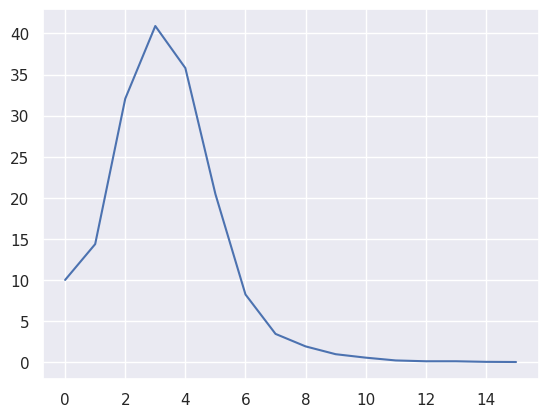

In [ ]:

plt.plot(average_new_nodes_infected)

[[4.9000e+02 4.5648e+02 3.8330e+02 3.0000e+02 2.2403e+02 1.6623e+02
  1.2499e+02 1.0511e+02 1.0194e+02 1.0032e+02 9.9620e+01 9.9160e+01
  9.8950e+01 9.8770e+01 9.8670e+01 9.8630e+01]
 [1.0000e+01 1.3090e+01 3.0030e+01 5.0340e+01 5.5830e+01 4.5310e+01
  2.9410e+01 1.8010e+01 1.0090e+01 5.7100e+00 3.0000e+00 1.6000e+00
  7.8000e-01 4.7000e-01 2.5000e-01 1.5000e-01]
 [0.0000e+00 3.0430e+01 8.6670e+01 1.4966e+02 2.2014e+02 2.8846e+02
  3.4560e+02 3.7688e+02 3.8797e+02 3.9397e+02 3.9738e+02 3.9924e+02
  4.0027e+02 4.0076e+02 4.0108e+02 4.0122e+02]]


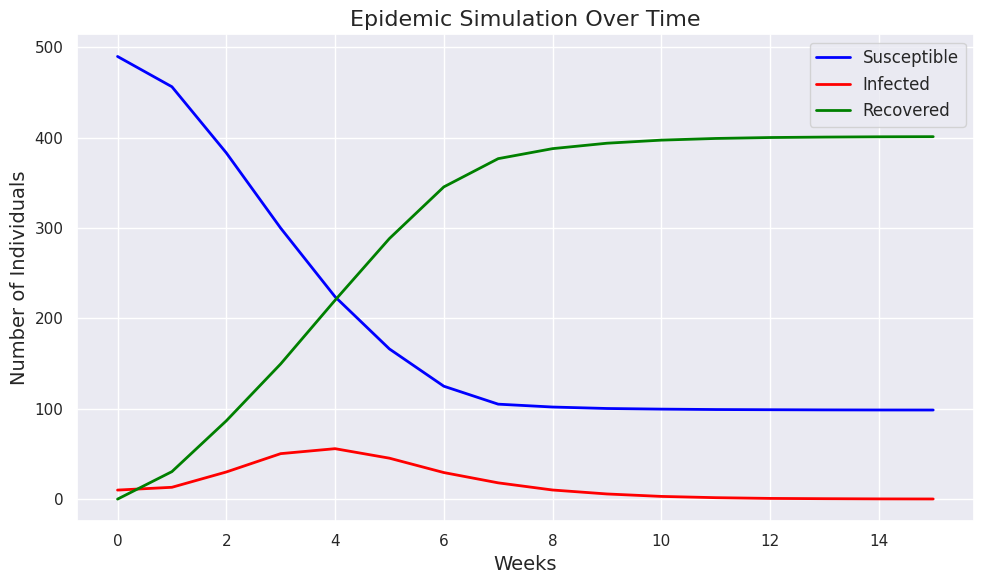

In [ ]:
# Extract and calculate the total number of S, I, and R nodes for each week
def calculate_average_states(simulations):
    time_limit = len(simulations[0][1])
    total_states = np.zeros((3, time_limit))  # For S, I, R
    for simulation in simulations: # Simulation has a tuple of matrix with 500 rows and 15 columns and a vector with the new infected
        states = simulation[0]  # Get the state history for each node
        for t in range(states.shape[1]): # states.shape[1] returns the number of weeks of the simulation
            # summing the number of S,I,R by each week
            total_states[0, t] += np.sum(states[:, t] == 0)  # Susceptible (S)
            total_states[1, t] += np.sum(states[:, t] == 1)  # Infected (I)
            total_states[2, t] += np.sum(states[:, t] == 2)  # Recovered (R)


    # Calculate the average across all simulations
    average_states = total_states / len(simulations) # we divide by the number of simulations length (simulations)
    return average_states

# Calculate the average states for S, I, R
average_states = calculate_average_states(S)
print (average_states)
# Plotting the results
time = range(week_to_simulate + 1)
plt.figure(figsize=(10, 6))

plt.plot(time, average_states[0], label='Susceptible', color='blue', linewidth=2)
plt.plot(time, average_states[1], label='Infected', color='red', linewidth=2)
plt.plot(time, average_states[2], label='Recovered', color='green', linewidth=2)

plt.title("Epidemic Simulation Over Time", fontsize=16)
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
_,b,_ = average_states

In [ ]:
b

array([10.  , 13.09, 30.03, 50.34, 55.83, 45.31, 29.41, 18.01, 10.09,
        5.71,  3.  ,  1.6 ,  0.78,  0.47,  0.25,  0.15])

# 1.4

In [ ]:
def MRSE(I):
    I = np.array(I)
    I_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0], dtype=float)
    return np.sqrt(np.mean((I - I_0) ** 2))


In [ ]:
def get_graph(n,k):
    G = preferential_attachment_graph(n, k)
    # Set initial state for nodes
    for node in initial_infected_nodes:
        G.nodes[node]['state'] = 'I'
        G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

    for node in G.nodes():
        if node not in initial_infected_nodes:
            G.nodes[node]['state'] = 'S'  # Default state for non-infected nodes
        G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated
    return G


In [ ]:
def gradient_descent( iterations = 1000, stopping_threshold = 1e-6):

    # Initializing weight, bias, learning rate and iterations
    n = 934
    k = 10
    beta = 0.3
    rho = 0.6

    delta_k = 1
    delta_beta = 0.1
    delta_rho = 0.1
    vacc_t = [0,5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
    set_k =    [k - delta_k, k, k + delta_k]
    set_beta = [beta - delta_beta, beta, beta + delta_beta]
    set_rho  = [rho - delta_rho , rho , rho + delta_rho ]
    permutations = [set_k, set_beta, set_rho]

    week_to_simulate = 15
    n_simulations = 10

    initial_infected_nodes = rng.choice(range(n), 10)

    current_weight = 0.1
    current_bias = 0.01
    iterations = iterations

    ks = []
    betas = []
    rhos = []
    costs = []
    previous_cost = None


    # Estimation of optimal parameters
    for i in range(iterations):


        #Run Simulations
        simulations  = dict({})
        bar = progressbar.ProgressBar(max_value=len(list(product(*permutations))))
        for j,param in enumerate(product(*permutations)):
            S_i = Simulations(get_graph(n,param[0]), param[1], param[2], time_limit = week_to_simulate, n_simulations=n_simulations, use_progressbar=False, vacc_t=vacc_t)
            I_hat=  np.mean([simulation[1] for simulation in S_i], axis=0)

            error_i = MRSE(I_hat)
            simulations[error_i]=param

            bar.update(j+1)


        bar.finish()


        min_error = np.min(list(simulations.keys()))

        costs.append(min_error)
        ks.append(k)
        betas.append(beta)
        rhos.append(rho)



        # If the change in cost is less than or equal to
        # stopping_threshold we stop the gradient descent
        if previous_cost and abs(previous_cost-min_error)<=stopping_threshold:
            break


        if  previous_cost :
        #     if previous_cost > min_error:

                # Updating weights and bias
            k = simulations[min_error][0]
            beta = round(simulations[min_error][1],3)
            rho = round(simulations[min_error][2],3)
            # else:
            #     delta_beta/=2
            #     delta_rho/=2


        set_k =    [k - delta_k, k, k + delta_k]
        set_beta = [beta - delta_beta, beta, beta + delta_beta]
        set_rho  = [rho - delta_rho , rho , rho + delta_rho ]
        permutations = [set_k, set_beta, set_rho]

        # Printing the parameters for each 1000th iteration
        print(f"Iteration {i+1}/{iterations}: MRSE {previous_cost}, k \
        {k}, Beta {beta}, Rho {rho}, delta_b {delta_beta},  delta_rho {delta_rho}")
        previous_cost = min_error

    # Visualizing the weights and cost at for all iterations
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(0,len(costs)), costs)
    plt.scatter(np.arange(0,len(costs)), costs, marker='o', color='red')
    plt.title("MRSE")
    plt.ylabel("MRSE")
    plt.xlabel("t")
    plt.show()


    return k, beta, rho, ks, betas, rhos,costs

In [ ]:
output = gradient_descent(stopping_threshold=1e-3)

100% (27 of 27) |########################| Elapsed Time: 0:00:26 Time:  0:00:260002


Iteration 1/1000: MRSE None, k         10, Beta 0.3, Rho 0.6, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:25 Time:  0:00:250002


Iteration 2/1000: MRSE 43.44114553047606, k         9, Beta 0.2, Rho 0.7, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:24 Time:  0:00:240002


Iteration 3/1000: MRSE 39.93195775315806, k         8, Beta 0.1, Rho 0.7, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:23 Time:  0:00:230002


Iteration 4/1000: MRSE 9.641025619714949, k         9, Beta 0.1, Rho 0.8, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:25 Time:  0:00:250002


Iteration 5/1000: MRSE 10.439827584783188, k         9, Beta 0.1, Rho 0.7, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:25 Time:  0:00:250002


Iteration 6/1000: MRSE 10.70875809793087, k         8, Beta 0.1, Rho 0.7, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:23 Time:  0:00:230002


Iteration 7/1000: MRSE 10.964032105024136, k         8, Beta 0.1, Rho 0.6, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:23 Time:  0:00:230002


Iteration 8/1000: MRSE 9.385460830454731, k         7, Beta 0.1, Rho 0.6, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:21 Time:  0:00:210002


Iteration 9/1000: MRSE 9.875822750535773, k         8, Beta 0.1, Rho 0.6, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:24 Time:  0:00:240002


Iteration 10/1000: MRSE 8.822910517510648, k         7, Beta 0.1, Rho 0.5, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:22 Time:  0:00:220002


Iteration 11/1000: MRSE 9.499440773013957, k         8, Beta 0.1, Rho 0.4, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:24 Time:  0:00:240002


Iteration 12/1000: MRSE 8.790939938368366, k         8, Beta 0.1, Rho 0.4, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:24 Time:  0:00:240002


Iteration 13/1000: MRSE 9.00409629002267, k         7, Beta 0.1, Rho 0.4, delta_b 0.1,  delta_rho 0.1


100% (27 of 27) |########################| Elapsed Time: 0:00:22 Time:  0:00:220002


Iteration 14/1000: MRSE 8.541991863728272, k         6, Beta 0.1, Rho 0.3, delta_b 0.1,  delta_rho 0.1


 40% (11 of 27) |#########               | Elapsed Time: 0:00:08 ETA:   0:00:12

In [ ]:
output

In [ ]:
s=  Simulations(get_graph(934,6), 0.3, 0.6, time_limit = 15, n_simulations=1, use_progressbar=True, vacc_t=[0,5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60])

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


[[924. 849. 702. 502. 313. 217. 157. 125. 107.  93.  92.  92.  92.  92.
   92.  92.]
 [ 10.  34. 125. 211. 230. 157.  93.  49.  25.  11.   7.   3.   0.   0.
    0.   0.]
 [  0.  51. 107. 221. 391. 560. 684. 760. 802. 830. 835. 839. 842. 842.
  842. 842.]]


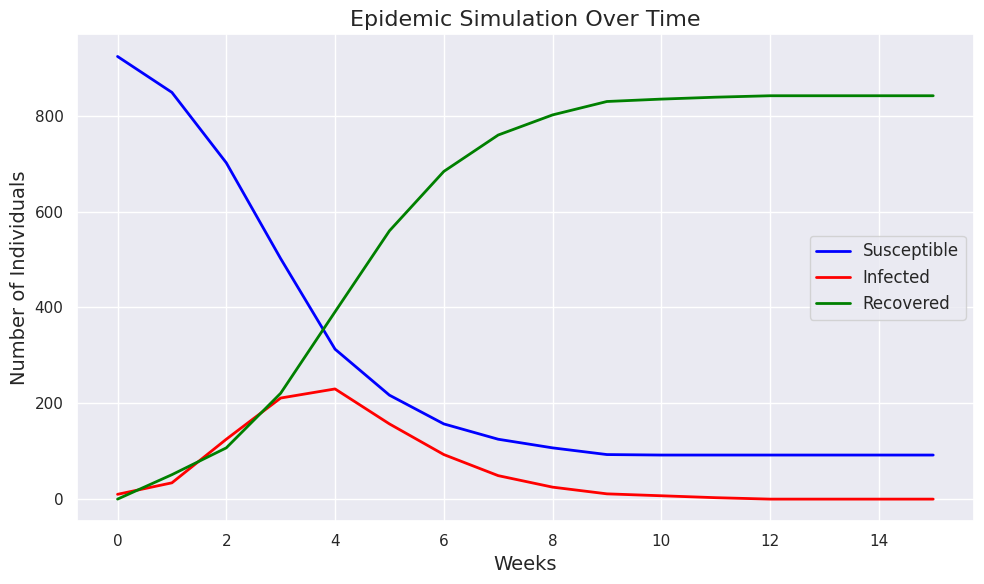

In [ ]:
average_states = calculate_average_states(s)
print (average_states)
# Plotting the results
time = range(week_to_simulate + 1)
plt.figure(figsize=(10, 6))

plt.plot(time, average_states[0], label='Susceptible', color='blue', linewidth=2)
plt.plot(time, average_states[1], label='Infected', color='red', linewidth=2)
plt.plot(time, average_states[2], label='Recovered', color='green', linewidth=2)

plt.title("Epidemic Simulation Over Time", fontsize=16)
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
MRSE(np.mean([simulation[1] for simulation in s], axis=0))

np.float64(57.466838263471566)

In [ ]:
np.mean([simulation[1] for simulation in s], axis=0)

array([ 10.,  28., 112., 152., 134.,  65.,  34.,  11.,   5.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [ ]:
[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

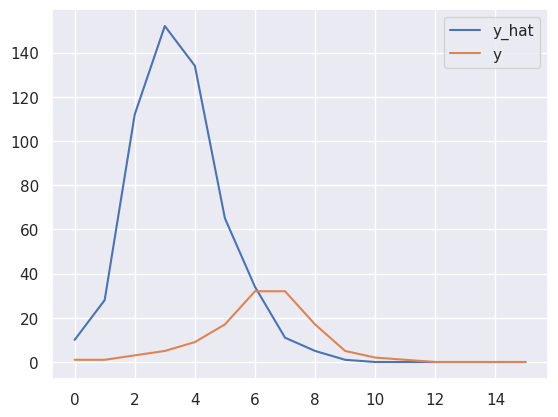

In [ ]:
plt.plot(np.mean([simulation[1] for simulation in s], axis=0), label='y_hat')
plt.plot([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0],label='y')
plt.legend()